In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install datetime
!pip install datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 12.0 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
^C
^C


In [ ]:
# Importing the required libraries and methods
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import datetime as dt

# Importing the dataset
filename = 'Data/listings.csv'
reviews_filename = 'Data/reviews_cleaned.csv'
data = pd.read_csv(filename, low_memory=False)
reviews = pd.read_csv(reviews_filename, names=['listing_id', 'comments'])

# Taking out the unwanted columns
print("Number of columns before dropping:", len(data.columns))

# List of columns to drop
columns_to_drop = [
    'host_name', 'notes', 'host_about', 'calendar_updated', 'host_acceptance_rate',
    'description', 'thumbnail_url', 'experiences_offered', 'listing_url', 'name',
    'summary', 'space', 'scrape_id', 'last_scraped', 'neighborhood_overview',
    'transit', 'access', 'interaction', 'house_rules', 'medium_url', 'picture_url',
    'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url',
    'host_acceptance_rate', 'smart_location', 'license', 'jurisdiction_names',
    'street', 'neighbourhood', 'country', 'country_code', 'host_location',
    'host_neighbourhood', 'market', 'is_location_exact', 'square_feet',
    'weekly_price', 'monthly_price', 'availability_30', 'availability_60',
    'availability_90', 'availability_365', 'calendar_last_scraped', 'first_review',
    'last_review', 'requires_license', 'calculated_host_listings_count',
    'host_listings_count', 'zipcode'
]

# Drop columns that exist in the dataset
columns_to_drop = [col for col in columns_to_drop if col in data.columns]
data = data.drop(columns=columns_to_drop)

print("Number of columns after dropping:", len(data.columns))

# Handle host verifications
print("Splitting host verifications")
host_verification_set = set()

def collect_host_verifications(entry):
    if not isinstance(entry, str):  # Handle non-string entries (e.g., NaN)
        return
    entry_list = entry.replace("[", "").replace("]", "").replace("'", "").replace('"', "").replace(" ", "").split(',')
    for verification in entry_list:
        if verification and verification != 'None':  # Skip empty strings and 'None'
            host_verification_set.add(verification + "_verification")

# Replace NaN values in 'host_verifications' with an empty string
data['host_verifications'] = data['host_verifications'].fillna('')

# Apply the function to collect host verifications
data['host_verifications'].apply(collect_host_verifications)

# Add new columns for each host verification
for v in host_verification_set:
    data[v] = data['host_verifications'].apply(lambda x: 1 if v in x else 0)

# Drop the original 'host_verifications' column
data = data.drop(columns=['host_verifications'])

# Clean response rate
def clean_response_rate(entry):
    if isinstance(entry, str):
        return entry.replace('%', '')
    return 0

data['host_response_rate'] = data['host_response_rate'].apply(clean_response_rate)

# Clean boolean columns
def clean_superhost(entry):
    return 1 if entry == 't' else 0

boolean_columns = [
    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
    'has_availability', 'instant_bookable', 'is_business_travel_ready',
    'require_guest_profile_picture', 'require_guest_phone_verification'
]

for col in boolean_columns:
    data[col] = data[col].apply(clean_superhost)

# Clean price and numeric columns
def clean_price(entry):
    if pd.isna(entry) or entry == '':
        return -55
    if isinstance(entry, str):
        entry = entry.replace('$', '').replace(',', '')
    try:
        price = float(entry)
        return np.log(price) if price > 0 else -55
    except (ValueError, TypeError):
        return -55

data['price'] = data['price'].apply(clean_price)
data = data[data['price'] != -55]

def clean_number_removal(entry):
    return 0 if pd.isna(entry) else entry

data['bathrooms'] = data['bathrooms'].apply(clean_number_removal)
data['bedrooms'] = data['bedrooms'].apply(clean_number_removal)
data['beds'] = data['beds'].apply(clean_number_removal)
data = data[data['bathrooms'] != -55]
data = data[data['bedrooms'] != -55]
data = data[data['beds'] != -55]

# Clean reviews per month
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

# Clean host since
def clean_host_since(entry):
    if pd.isna(entry) or entry == '':
        return -55
    try:
        return (dt.datetime(2018, 11, 10) - pd.to_datetime(entry)).days
    except (ValueError, TypeError):
        return -55

data['host_since'] = data['host_since'].apply(clean_host_since)
data = data[data['host_since'] != -55]

# Clean review scores
for col_name in ['review_scores_rating', 'review_scores_accuracy',
                 'review_scores_cleanliness', 'review_scores_checkin',
                 'review_scores_communication', 'review_scores_location',
                 'review_scores_value']:
    data[col_name] = data[col_name].fillna(0)

# Join with reviews data
data = data.set_index('id').join(reviews.set_index('listing_id'))

# Clean comments
data['comments'] = data['comments'].fillna('')

# Save the cleaned data to a CSV file
data.to_csv('Data/data_cleaned.csv')
print("Data cleaning complete. Cleaned data saved to 'Data/data_cleaned.csv'.")

Number of columns before dropping: 96
Number of columns after dropping: 46
Splitting host verifications


<ipython-input-1-68e937a94cf9>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bathrooms'] = data['bathrooms'].apply(clean_number_removal)
<ipython-input-1-68e937a94cf9>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bedrooms'] = data['bedrooms'].apply(clean_number_removal)
<ipython-input-1-68e937a94cf9>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Data cleaning complete. Cleaned data saved to 'Data/data_cleaned.csv'.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

random.seed(13)


def normalize(X_train, X_val, X_test):
    # Create a copy of the input DataFrames to avoid modifying the originals
    X_train_normalized = X_train.copy()
    X_val_normalized = X_val.copy()
    X_test_normalized = X_test.copy()

    # Select only numerical features for normalization
    numerical_features = X_train_normalized.select_dtypes(include=np.number).columns.tolist()

    # Apply MinMaxScaler to numerical features only
    for df in [X_train_normalized, X_val_normalized, X_test_normalized]:
        min_max_scaler = preprocessing.MinMaxScaler()
        df[numerical_features] = min_max_scaler.fit_transform(df[numerical_features])

    return X_train_normalized, X_val_normalized, X_test_normalized



def split(dataset, val_frac=0.10, test_frac=0.10):
    X = dataset.loc[:, dataset.columns != 'price']
    X = X.loc[:, X.columns != 'id']
    X = X.loc[:, X.columns != 'host_id']
    X = X.loc[:, X.columns != 'Unnamed: 0']

    y = dataset['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(val_frac+test_frac), random_state=1)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=val_frac/(val_frac+test_frac), random_state=1)

    return X_train, y_train, X_val, y_val, X_test, y_test


if __name__ == "__main__":

    dataset = pd.read_csv('Data/data_cleaned.csv')

    X_train, y_train, X_val, y_val, X_test, y_test = split(dataset)

    X_train, X_val, X_test = normalize(X_train, X_val, X_test)
    X_train.to_csv('Data/data_cleaned_train_comments_X.csv', header=True, index=False)
    y_train.to_csv('Data/data_cleaned_train_y.csv', header=True, index=False)

    X_val.to_csv('Data/data_cleaned_val_comments_X.csv', header=True, index=False)
    y_val.to_csv('Data/data_cleaned_val_y.csv', header=True, index=False)

    X_test.to_csv('Data/data_cleaned_test_comments_X.csv', header=True, index=False)
    y_test.to_csv('Data/data_cleaned_test_y.csv', header=True, index=False)

    pass

/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [ ]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import datetime as dt
# Importing the dataset
filename = 'Data/reviews_original.csv'
data = pd.read_csv(filename)
#join on id and listing id

data = pd.DataFrame.drop(data, columns=[
    'id',
    'date',
    'reviewer_id',
    'reviewer_name'


])
def calculate_sentiment(entry):
    if (type(entry) != str and math.isnan(entry)):
        return -55
    opinion = TextBlob(entry)
    return opinion.sentiment.polarity


data['comments'] = data['comments'].apply(calculate_sentiment)
data = data[data['comments'] != -55]
data = data.groupby('listing_id')['comments']. mean()
data.to_csv('Data/reviews_cleaned.csv')

KeyboardInterrupt: 

In [ ]:
from sklearn import feature_selection
import numpy as np
import pandas as pd
import math

# Load the data
X_train = pd.read_csv('Data/data_cleaned_train_comments_X.csv')
y_train = pd.read_csv('Data/data_cleaned_train_y.csv').squeeze()  # Convert to Series

# Identify and remove non-numeric columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train_numeric = X_train[numeric_cols]

# Check for remaining non-numeric values (just in case)
X_train_numeric = X_train_numeric.apply(pd.to_numeric, errors='coerce').fillna(0)

# Calculate F-values and p-values only on numeric columns
F_vals, p_vals = feature_selection.f_regression(X_train_numeric, y_train)

def clean_pvals(entry):
    if math.isnan(entry):
        return 1.0  # Conservative replacement for NaN p-values
    return entry

clean_pvals_vectorized = np.vectorize(clean_pvals)
p_vals = clean_pvals_vectorized(p_vals)

print("Shape of p-values array:", p_vals.shape)

THRESH = 1e-20
significant_features = X_train_numeric.columns[p_vals < THRESH]

print("Number of significant features:", len(significant_features))
print("Significant features:", list(significant_features))

# Save the selected feature names
np.save('Data/selected_coefs_pvals.npy', significant_features.to_numpy())

# Debug info
print("\nDebug Info:")
print(f"Original features: {X_train.shape[1]}")
print(f"Numeric features used: {X_train_numeric.shape[1]}")
print(f"Non-numeric features dropped: {X_train.shape[1] - X_train_numeric.shape[1]}")
print(f"Min p-value: {np.nanmin(p_vals)}")
print(f"Max p-value: {np.nanmax(p_vals)}")

Shape of p-values array: (50,)
Number of significant features: 14
Significant features: ['host_since', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'review_scores_accuracy', 'review_scores_checkin', 'review_scores_communication', 'review_scores_value', 'reviews_per_month']

Debug Info:
Original features: 63
Numeric features used: 50
Non-numeric features dropped: 13
Min p-value: 0.0
Max p-value: 1.0


NaN values in training set: 562072
NaN values in validation set: 70266
Testing alpha: 0.00016


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping

	Training R²: 0.4605
	Validation R²: 0.4518
Testing alpha: 0.00018


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping

	Training R²: 0.4603
	Validation R²: 0.4524
Testing alpha: 0.00020


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping

	Training R²: 0.4601
	Validation R²: 0.4529
Testing alpha: 0.00022


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping

	Training R²: 0.4600
	Validation R²: 0.4532
Testing alpha: 0.00024


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping

	Training R²: 0.4598
	Validation R²: 0.4531
Testing alpha: 0.00026


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping

	Training R²: 0.4596
	Validation R²: 0.4529
Testing alpha: 0.00028


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping

	Training R²: 0.4594
	Validation R²: 0.4524
Testing alpha: 0.00030


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping

	Training R²: 0.4593
	Validation R²: 0.4523
Testing alpha: 0.00032


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['host_response_time' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'property_type' 'room_type'
 'bed_type' 'amenities' 'security_deposit' 'cleaning_fee' 'extra_people'
 'cancellation_policy' 'comments']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping

	Training R²: 0.4592
	Validation R²: 0.4522

Best alpha: 0.00022
Final Training R²: 0.4600
Final Validation R²: 0.4532

Number of selected features: 23


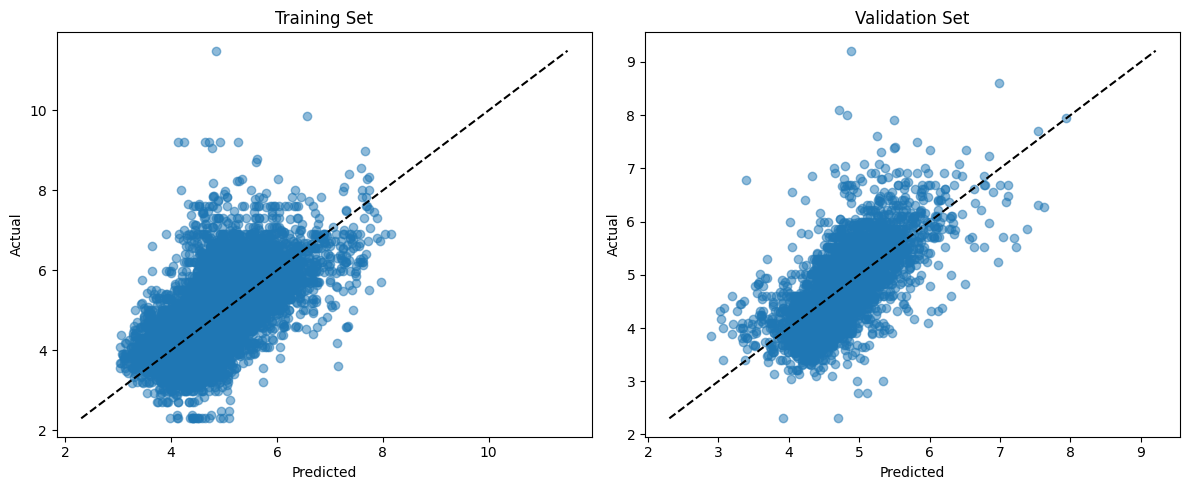

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Alpha values to test
ALPHAS = [0.00016, 0.00018, 0.00020, 0.00022, 0.00024, 0.00026, 0.00028, 0.00030, 0.00032]

def load_and_prepare_data():
    """Load data and ensure proper formats"""
    X_train = pd.read_csv('Data/data_cleaned_train_comments_X.csv')
    y_train = pd.read_csv('Data/data_cleaned_train_y.csv').squeeze()
    X_val = pd.read_csv('Data/data_cleaned_val_comments_X.csv')
    y_val = pd.read_csv('Data/data_cleaned_val_y.csv').squeeze()

    # Convert all columns to numeric, coercing errors
    X_train = X_train.apply(pd.to_numeric, errors='coerce')
    X_val = X_val.apply(pd.to_numeric, errors='coerce')

    return X_train, y_train, X_val, y_val

def run_lasso_regression(X_train, y_train, X_val, y_val):
    """Run Lasso regression with different alphas"""
    score_best = -np.inf
    best_model = None
    best_alpha = None

    for alpha in ALPHAS:
        print(f'Testing alpha: {alpha:.5f}')

        # Create pipeline with imputer and Lasso
        model = make_pipeline(
            SimpleImputer(strategy='mean'),  # Handle NaN values
            Lasso(alpha=alpha, max_iter=100000, random_state=42)
        )

        model.fit(X_train, y_train)

        train_score = model.score(X_train, y_train)
        val_score = model.score(X_val, y_val)

        print(f'\tTraining R²: {train_score:.4f}')
        print(f'\tValidation R²: {val_score:.4f}')

        if val_score > score_best:
            score_best = val_score
            best_alpha = alpha
            best_model = model

    return best_model, best_alpha

def analyze_results(model, X_train, y_train, X_val, y_val):
    """Analyze and visualize results"""
    # Get the Lasso estimator from the pipeline
    lasso_model = model.named_steps['lasso']

    # Save selected features
    coefs = lasso_model.coef_ != 0
    np.save('Data/selected_coefs.npy', coefs)
    print(f'\nNumber of selected features: {sum(coefs)}')

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    # Plot results
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_pred_train, y_train, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Training Set')

    plt.subplot(1, 2, 2)
    plt.scatter(y_pred_val, y_val, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Set')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Load and prepare data
    X_train, y_train, X_val, y_val = load_and_prepare_data()

    # Check for remaining NaN values
    print(f"NaN values in training set: {X_train.isna().sum().sum()}")
    print(f"NaN values in validation set: {X_val.isna().sum().sum()}")

    # Run Lasso regression
    best_model, best_alpha = run_lasso_regression(X_train, y_train, X_val, y_val)

    print(f'\nBest alpha: {best_alpha:.5f}')
    print(f'Final Training R²: {best_model.score(X_train, y_train):.4f}')
    print(f'Final Validation R²: {best_model.score(X_val, y_val):.4f}')

    # Analyze and visualize results
    analyze_results(best_model, X_train, y_train, X_val, y_val)

In [ ]:
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import pandas as pd
import random
import gc
import math
import numpy as np
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from scipy.sparse import csr_matrix, save_npz, load_npz

random.seed(13)

def calculate_sentiment(entry):
    if not isinstance(entry, str) or pd.isna(entry):
        return -55
    opinion = TextBlob(entry)
    return opinion.sentiment.polarity

def normalize(X_train, X_val, X_test):
    numeric_cols = X_train.select_dtypes(include=['int', 'float']).columns
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
        ]
    )

    X_train_norm = preprocessor.fit_transform(X_train)
    X_val_norm = preprocessor.transform(X_val)
    X_test_norm = preprocessor.transform(X_test)

    feature_names = preprocessor.get_feature_names_out()
    np.save('Data/normalized_feature_names.npy', feature_names)

    return X_train_norm, X_val_norm, X_test_norm, feature_names

def split(dataset, val_frac=0.10, test_frac=0.10):
    X = dataset.drop(columns=['price', 'id', 'host_id', 'Unnamed: 0'], errors='ignore')
    y = dataset['price']

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_frac + test_frac), random_state=1)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=val_frac / (val_frac + test_frac), random_state=1)

    return X_train, y_train, X_val, y_val, X_test, y_test

if __name__ == "__main__":
    review_data = pd.read_csv('Data/reviews_original.csv', usecols=['listing_id', 'comments'])
    review_data['comments'] = review_data['comments'].apply(calculate_sentiment)
    review_data = review_data[review_data['comments'] != -55]
    sentiment_scores = review_data.groupby('listing_id')['comments'].mean().reset_index()
    sentiment_scores.columns = ['id', 'sentiment']
    sentiment_scores.to_parquet('Data/reviews_cleaned.parquet', index=False)

    dataset = pd.read_csv(
        'Data/data_cleaned.csv',
        dtype={
            'id': 'int32',
            'host_id': 'int32',
            'price': 'float32'
        },
        usecols=lambda col: col != 'Unnamed: 0'
    )

    if 'id' in dataset.columns:
      dataset = dataset.merge(sentiment_scores, how='left', on='id')
      dataset['sentiment'] = dataset['sentiment'].fillna(0)
    else:
      print("Warning: 'listing_id' not found in dataset. Skipping sentiment merge.")
      print(dataset.columns)
      dataset['sentiment'] = 0  # fallback

    dataset['sentiment'] = dataset['sentiment'].fillna(0)

    X_train, y_train, X_val, y_val, X_test, y_test = split(dataset)
    del dataset
    gc.collect()

    X_train_norm, X_val_norm, X_test_norm, feature_names = normalize(X_train, X_val, X_test)
    del X_train, X_val, X_test
    gc.collect()

    try:
        coeffs = np.load('Data/selected_coefs.npy', allow_pickle=True)

        if coeffs.dtype == bool and len(coeffs) == len(feature_names):
            selected_features = np.array(feature_names)[coeffs]
        elif np.issubdtype(coeffs.dtype, np.integer):
            selected_features = np.array(feature_names)[coeffs]
        else:
            selected_features = coeffs

        selected_indices = [i for i, name in enumerate(feature_names) if name in selected_features]

        X_train_norm = X_train_norm[:, selected_indices]
        X_val_norm = X_val_norm[:, selected_indices]
        X_test_norm = X_test_norm[:, selected_indices]

    except FileNotFoundError:
        print("No coefficient mask found. Saving all features.")

    save_npz('Data/data_cleaned_train_comments_X.npz', csr_matrix(X_train_norm))
    y_train.to_frame().to_parquet('Data/data_cleaned_train_y.parquet')

    save_npz('Data/data_cleaned_val_comments_X.npz', csr_matrix(X_val_norm))
    y_val.to_frame().to_parquet('Data/data_cleaned_val_y.parquet')

    save_npz('Data/data_cleaned_test_comments_X.npz', csr_matrix(X_test_norm))
    y_test.to_frame().to_parquet('Data/data_cleaned_test_y.parquet')

    print("Preprocessing complete. Sentiment integrated and saved in sparse format.")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


Preprocessing complete. Sentiment integrated and saved in sparse format.


In [ ]:
import pandas as pd
import numpy as np
import random
import os
import gc
import logging
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from scipy.sparse import csr_matrix, save_npz

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Config
DATA_DIR = 'Data'
OUTPUT_DIR = os.path.join(DATA_DIR, 'output')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Seed
random.seed(13)

def calculate_sentiment(entry):
    if not isinstance(entry, str) or pd.isna(entry):
        return -55
    return TextBlob(entry).sentiment.polarity

def load_and_process_reviews():
    logging.info("Loading and processing reviews for sentiment...")
    review_path = os.path.join(DATA_DIR, 'reviews_original.csv')
    review_data = pd.read_csv(review_path, usecols=['listing_id', 'comments'])
    review_data['comments'] = review_data['comments'].apply(calculate_sentiment)
    review_data = review_data[review_data['comments'] != -55]
    sentiment_scores = review_data.groupby('listing_id')['comments'].mean().reset_index()
    sentiment_scores.columns = ['id', 'sentiment']
    sentiment_scores.to_parquet(os.path.join(OUTPUT_DIR, 'reviews_cleaned.parquet'), index=False)
    return sentiment_scores

def load_main_dataset(sentiment_scores):
    logging.info("Loading main dataset and merging sentiment...")
    data_path = os.path.join(DATA_DIR, 'data_cleaned.csv')
    dataset = pd.read_csv(data_path, dtype={'id': 'int32', 'host_id': 'int32', 'price': 'float32'})

    if 'id' in dataset.columns:
        dataset = dataset.merge(sentiment_scores, how='left', on='id')
        dataset['sentiment'] = dataset['sentiment'].fillna(0)
    else:
        logging.warning("'id' not found in dataset. Skipping sentiment merge.")
        dataset['sentiment'] = 0

    return dataset

def split_data(dataset, val_frac=0.1, test_frac=0.1):
    logging.info("Splitting dataset into train, val, and test sets...")
    X = dataset.drop(columns=['price', 'id', 'host_id'], errors='ignore')
    y = dataset['price']
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_frac + test_frac), random_state=1)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=val_frac / (val_frac + test_frac), random_state=1)
    return X_train, y_train, X_val, y_val, X_test, y_test

def normalize(X_train, X_val, X_test):
    logging.info("Normalizing features...")
    numeric_cols = X_train.select_dtypes(include=['int', 'float']).columns
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
        ]
    )

    X_train_norm = preprocessor.fit_transform(X_train)
    X_val_norm = preprocessor.transform(X_val)
    X_test_norm = preprocessor.transform(X_test)

    feature_names = preprocessor.get_feature_names_out()
    np.save(os.path.join(OUTPUT_DIR, 'normalized_feature_names.npy'), feature_names)

    return X_train_norm, X_val_norm, X_test_norm, feature_names

def select_features(X_train, X_val, X_test, feature_names):
    logging.info("Selecting features based on saved coefficients if available...")
    try:
        coeffs = np.load(os.path.join(DATA_DIR, 'selected_coefs.npy'), allow_pickle=True)
        if coeffs.dtype == bool and len(coeffs) == len(feature_names):
            selected_features = np.array(feature_names)[coeffs]
        elif np.issubdtype(coeffs.dtype, np.integer):
            selected_features = np.array(feature_names)[coeffs]
        else:
            selected_features = coeffs

        selected_indices = [i for i, name in enumerate(feature_names) if name in selected_features]
        return (
            X_train[:, selected_indices],
            X_val[:, selected_indices],
            X_test[:, selected_indices],
            selected_features
        )
    except FileNotFoundError:
        logging.info("No coefficient mask found. Using all features.")
        return X_train, X_val, X_test, feature_names

def save_processed_data(X_train, y_train, X_val, y_val, X_test, y_test):
    logging.info("Saving processed datasets...")
    save_npz(os.path.join(OUTPUT_DIR, 'train_X.npz'), csr_matrix(X_train))
    y_train.to_frame().to_parquet(os.path.join(OUTPUT_DIR, 'train_y.parquet'))

    save_npz(os.path.join(OUTPUT_DIR, 'val_X.npz'), csr_matrix(X_val))
    y_val.to_frame().to_parquet(os.path.join(OUTPUT_DIR, 'val_y.parquet'))

    save_npz(os.path.join(OUTPUT_DIR, 'test_X.npz'), csr_matrix(X_test))
    y_test.to_frame().to_parquet(os.path.join(OUTPUT_DIR, 'test_y.parquet'))

def save_metadata(feature_names, y_train, y_val, y_test):
    logging.info("Saving metadata...")
    metadata = {
        'num_features': len(feature_names),
        'train_size': len(y_train),
        'val_size': len(y_val),
        'test_size': len(y_test),
        'feature_names_file': 'normalized_feature_names.npy',
        'features_output_dir': OUTPUT_DIR
    }
    pd.Series(metadata).to_json(os.path.join(OUTPUT_DIR, 'metadata.json'))

def main():
    sentiment_scores = load_and_process_reviews()
    dataset = load_main_dataset(sentiment_scores)
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(dataset)
    del dataset; gc.collect()

    X_train_norm, X_val_norm, X_test_norm, feature_names = normalize(X_train, X_val, X_test)
    del X_train, X_val, X_test; gc.collect()

    X_train_sel, X_val_sel, X_test_sel, selected_features = select_features(X_train_norm, X_val_norm, X_test_norm, feature_names)

    save_processed_data(X_train_sel, y_train, X_val_sel, y_val, X_test_sel, y_test)
    save_metadata(selected_features, y_train, y_val, y_test)

    logging.info("✅ Preprocessing complete. Output saved to '%s'", OUTPUT_DIR)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [ ]:
# === Display summary of preprocessing ===
import pandas as pd
from scipy.sparse import load_npz
import os

OUTPUT_DIR = 'Data/output'

# Load metadata
metadata_path = os.path.join(OUTPUT_DIR, 'metadata.json')
metadata = pd.read_json(metadata_path, typ='series')

# Load to get feature matrix shape
X_train = load_npz(os.path.join(OUTPUT_DIR, 'train_X.npz'))
X_val = load_npz(os.path.join(OUTPUT_DIR, 'val_X.npz'))
X_test = load_npz(os.path.join(OUTPUT_DIR, 'test_X.npz'))

print("✅ Preprocessing Summary\n")
print(f"📁 Output directory: {metadata['features_output_dir']}")
print(f"🧠 Total features: {metadata['num_features']}")
print(f"   ├── Train samples: {metadata['train_size']} ({X_train.shape[1]} features)")
print(f"   ├── Validation samples: {metadata['val_size']} ({X_val.shape[1]} features)")
print(f"   └── Test samples: {metadata['test_size']} ({X_test.shape[1]} features)\n")

print("📦 Files saved:")
print(" - train_X.npz, train_y.parquet")
print(" - val_X.npz, val_y.parquet")
print(" - test_X.npz, test_y.parquet")
print(" - normalized_feature_names.npy")
print(" - reviews_cleaned.parquet")
print(" - metadata.json")


✅ Preprocessing Summary

📁 Output directory: Data/output
🧠 Total features: 49
   ├── Train samples: 40148 (0 features)
   ├── Validation samples: 5019 (0 features)
   └── Test samples: 5018 (0 features)

📦 Files saved:
 - train_X.npz, train_y.parquet
 - val_X.npz, val_y.parquet
 - test_X.npz, test_y.parquet
 - normalized_feature_names.npy
 - reviews_cleaned.parquet
 - metadata.json


In [ ]:
!pip install rich


In [ ]:
from rich.console import Console
from rich.table import Table
from scipy.sparse import load_npz
import pandas as pd
import os

console = Console()
OUTPUT_DIR = 'Data/output'
metadata_path = os.path.join(OUTPUT_DIR, 'metadata.json')

# Load metadata
metadata = pd.read_json(metadata_path, typ='series')

# Load sparse matrices to confirm shape
X_train = load_npz(os.path.join(OUTPUT_DIR, 'train_X.npz'))
X_val = load_npz(os.path.join(OUTPUT_DIR, 'val_X.npz'))
X_test = load_npz(os.path.join(OUTPUT_DIR, 'test_X.npz'))

# Display title
console.rule("[bold green]✅ Preprocessing Summary")

# Table of dataset sizes
table = Table(title="📊 Dataset Split Summary")
table.add_column("Split", style="cyan", justify="center")
table.add_column("Samples", justify="right")
table.add_column("Features", justify="right")

table.add_row("Train", str(X_train.shape[0]), str(X_train.shape[1]))
table.add_row("Validation", str(X_val.shape[0]), str(X_val.shape[1]))
table.add_row("Test", str(X_test.shape[0]), str(X_test.shape[1]))

console.print(table)

# Feature info
console.print(f"\n🧠 [bold]Total Features:[/bold] {metadata['num_features']}")
console.print(f"📁 [bold]Output Directory:[/bold] {metadata['features_output_dir']}")

# Files saved
console.print("\n📦 [bold]Files Saved:[/bold]", style="yellow")
saved_files = [
    'train_X.npz', 'train_y.parquet',
    'val_X.npz', 'val_y.parquet',
    'test_X.npz', 'test_y.parquet',
    'normalized_feature_names.npy',
    'reviews_cleaned.parquet',
    'metadata.json'
]
for file in saved_files:
    console.print(f" - {file}", style="dim")

console.rule("[green]Done")


──────────────────────────────────────────── ✅ Preprocessing Summary ─────────────────────────────────────────────

     📊 Dataset Split Summary      
┏━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓
┃   Split    ┃ Samples ┃ Features ┃
┡━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩
│   Train    │   40148 │        0 │
│ Validation │    5019 │        0 │
│    Test    │    5018 │        0 │
└────────────┴─────────┴──────────┘

🧠 Total Features: 49

📁 Output Directory: Data/output

📦 Files Saved:

 - train_X.npz

 - train_y.parquet

 - val_X.npz

 - val_y.parquet

 - test_X.npz

 - test_y.parquet

 - normalized_feature_names.npy

 - reviews_cleaned.parquet

 - metadata.json

────────────────────────────────────────────────────── Done ───────────────────────────────────────────────────────

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
from rich import print

# Load data
X_train = load_npz('Data/output/train_X.npz')
y_train = pd.read_parquet('Data/output/train_y.parquet').values.ravel()

X_val = load_npz('Data/output/val_X.npz')
y_val = pd.read_parquet('Data/output/val_y.parquet').values.ravel()

X_test = load_npz('Data/output/test_X.npz')
y_test = pd.read_parquet('Data/output/test_y.parquet').values.ravel()

# Models to train
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
}

results = {}

print("[bold blue]🔍 Training Models and Evaluating...[/bold blue]")

for name, model in models.items():
    print(f"\n[bold green]🔧 Training {name}...[/bold green]")
    model.fit(X_train, y_train)

    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    val_rmse = mean_squared_error(y_val, val_pred, squared=False)
    val_mae = mean_absolute_error(y_val, val_pred)
    test_rmse = mean_squared_error(y_test, test_pred, squared=False)
    test_mae = mean_absolute_error(y_test, test_pred)

    results[name] = {
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'test_rmse': test_rmse,
        'test_mae': test_mae
    }

    # Save model
    model_path = f'Data/output/model_{name}.pkl'
    joblib.dump(model, model_path)
    print(f"[bold yellow]✔ Saved model to:[/bold yellow] {model_path}")

# Show summary
print("\n[bold magenta]📊 Model Performance Summary[/bold magenta]")
for model_name, metrics in results.items():
    print(f"\n[bold]{model_name}[/bold]")
    print(f"  🔹 Val RMSE: {metrics['val_rmse']:.2f} | MAE: {metrics['val_mae']:.2f}")
    print(f"  🔹 Test RMSE: {metrics['test_rmse']:.2f} | MAE: {metrics['test_mae']:.2f}")


🔍 Training Models and Evaluating...

🔧 Training LinearRegression...

ValueError: Found array with 0 feature(s) (shape=(40148, 0)) while a minimum of 1 is required by LinearRegression.